In [54]:
import glob
import json
import matplotlib
import numpy as np
import pandas as pd
import xnetwork as xnet
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from functools import partial
from collections import defaultdict
from multiprocessing import Pool
from matplotlib.ticker import MaxNLocator


In [59]:
def cit_papercount(row):
    return pd.Series({'cits':len(row), 'journal':row['cited_journal'].iloc[0], 'comm': row['cited_comm'].iloc[0]})


def get_impact_factor(current_journal):
    files = glob.glob('../data/citing_valid*.csv')
    all_info = []
    for file in files:
        print(file)    
        df = pd.read_csv(file, sep='\t', header=None)
        df.columns = ['citing', 'year', 'cited', 'cited_journal', 'cited_comm']
        all_info.append(df)
    
    print("citing data...")
    all_info = pd.concat(all_info)
    all_info_cits = all_info[all_info['cited_journal'] == current_journal]
    all_info_cits = all_info_cits.groupby(['cited_journal','cited_comm', 'year']).count()
    
    # get numer of papers per year
    print("papers count...")
    valid_ids_files = glob.glob('../data/valid_ids*')
    valid_ids_list = []
    for file in valid_ids_files:
        valid_ids_list.append(pd.read_csv(file, sep='\t', names=['wos_id', 'comm', 'year', 'journal']))
    
    
    valid_ids = pd.concat(valid_ids_list)
    
    
    valid_ids_grouped = valid_ids[valid_ids['journal'] == current_journal]
    
    
    valid_ids_grouped = valid_ids_grouped.groupby(['year', 'comm', 'journal'], as_index=False).count()
#     print(valid_ids_grouped.columns)
    
    data = defaultdict(lambda:defaultdict(lambda:[]))

    print('calculating impact factor...')
    for key,cit_count in all_info_cits.iterrows():
        journal, comm, year = key
        
        if year < 1986 or year > 2022:
            continue
        
        # verificar o plot do tamanho das comunidades e comparar com os dados daqui
        papers1 = valid_ids_grouped.loc[(valid_ids_grouped['journal'] == journal)
                                       & (valid_ids_grouped['comm'] == comm)
                                       & (valid_ids_grouped['year'] == year-1)]
        papers2 = valid_ids_grouped.loc[(valid_ids_grouped['journal'] == journal)
                               & (valid_ids_grouped['comm'] == comm)
                               & (valid_ids_grouped['year'] == year-2)]
        
        # calcular o fator de impacto da revista (como referencia)
        if len(papers1) > 0:
            papers_count = papers1['wos_id'].iloc[0]
        else:
            papers_count = 0
        
        if len(papers2) > 0:
            papers_count += papers2['wos_id'].iloc[0]
        
        cit_count = cit_count.iloc[0]
        impact_factor = cit_count/papers_count
        data[journal][comm].append((year, impact_factor))

    output = open('impact_factor_{}_2022_details.json'.format(current_journal), 'w')
    output.write(json.dumps(data))
    output.close()
        
get_impact_factor('chem. mat.')

../data/citing_valid_0.csv
../data/citing_valid_1.csv
../data/citing_valid_2.csv
../data/citing_valid_3.csv
../data/citing_valid_4.csv
../data/citing_valid_5.csv
citing data...
papers count...
calculating impact factor...


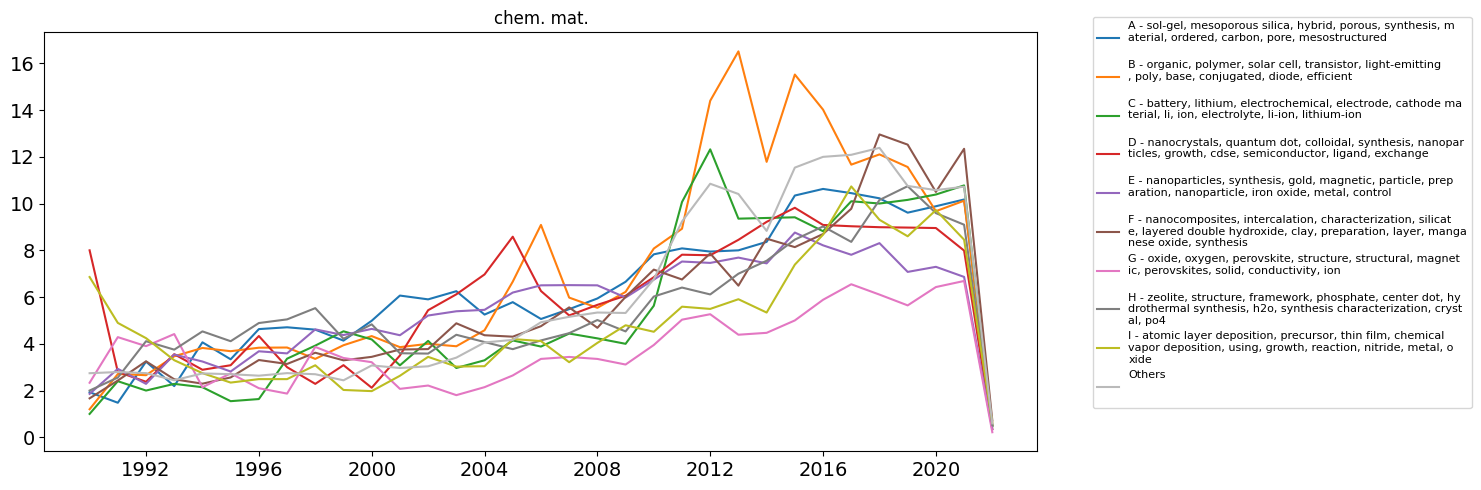

In [60]:

def plot_impact_factor(journal):
    cmap = plt.get_cmap("tab10")
    outer_colors = cmap(np.arange(10))
    outer_colors[-1][0] = 0.73
    outer_colors[-1][1] = 0.73
    outer_colors[-1][2] = 0.73
    outer_colors[-1][3] = 1.0
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14) 
    
    data = json.loads(open('impact_factor_{}_2022_details.json'.format(journal)).read())
    for journal, comms_data in data.items():
        fg = plt.figure(figsize=(15, 5))
        ax = fg.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        i = 0
        for comm, year_data in comms_data.items():
            X = []
            Y = []
            for x,y in year_data:
                X.append(x)
                Y.append(y)
            label = comm[:60] + '\n' + comm[60:120] + '\n' + comm[120:]
            plt.plot(X, Y, label=label, color=outer_colors[i])
            i += 1
        plt.title(journal)
        plt.legend(prop={'size': 8}, bbox_to_anchor=(1.05,1.05))
        plt.tight_layout()
        plt.savefig('../results/{}_impact_factor_2020.pdf'.format(journal))
        
        
plot_impact_factor('chem. mat.')

In [ ]:
# TODO fazer para janela de tempo

In [80]:
files = glob.glob('cit_net_windows/citing_net_chem. mat._time_*_bardo_infomap.xnet')
print(files)

['cit_net_windows/citing_net_chem. mat._time_windows_1988_1992_2023-05-30_bardo_infomap.xnet', 'cit_net_windows/citing_net_chem. mat._time_windows_1993_1997_2023-05-30_bardo_infomap.xnet', 'cit_net_windows/citing_net_chem. mat._time_windows_1998_2002_2023-05-30_bardo_infomap.xnet', 'cit_net_windows/citing_net_chem. mat._time_windows_2003_2007_2023-05-30_bardo_infomap.xnet', 'cit_net_windows/citing_net_chem. mat._time_windows_2008_2012_2023-05-30_bardo_infomap.xnet', 'cit_net_windows/citing_net_chem. mat._time_windows_2013_2017_2023-05-30_bardo_infomap.xnet', 'cit_net_windows/citing_net_chem. mat._time_windows_2018_2022_2023-05-30_bardo_infomap.xnet']


In [91]:
def cit_papercount(row):
    return pd.Series({'cits':len(row), 'journal':row['cited_journal'].iloc[0], 'comm': row['cited_comm'].iloc[0]})


def get_impact_factor_for_window(current_net):
    
    valid_papers = current_net.vs['wos_id']
    comms = current_net.vs['Cluster Name']
        
    paper2comm = dict()
    for v,c in zip(valid_papers, comms):
        paper2comm[v] = c
    
    files = glob.glob('../data/citing_valid*.csv')
    all_info = []
    for file in files:
        df = pd.read_csv(file, sep='\t', header=None)
        df.columns = ['citing', 'year', 'cited', 'cited_journal', 'cited_comm']
        all_info.append(df)
    
    print("citing data...")
    all_info = pd.concat(all_info)
    all_info_cits = all_info[all_info['cited'].isin(valid_papers)]
    cited_comm = []
    for _,row in all_info_cits.iterrows():
        comm = paper2comm[row['cited']]
        cited_comm.append(comm)
    all_info_cits.loc[:,'cited_comm'] = cited_comm
    
    all_info_cits = all_info_cits.groupby(['cited_journal','cited_comm', 'year']).count()
    
    # get numer of papers per year
    print("papers count...")
    valid_ids_files = glob.glob('../data/valid_ids*')
    valid_ids_list = []
    for file in valid_ids_files:
        valid_ids_list.append(pd.read_csv(file, sep='\t', names=['wos_id', 'comm', 'year', 'journal']))
    
    
    valid_ids = pd.concat(valid_ids_list)
    valid_ids = valid_ids[valid_ids['wos_id'].isin(valid_papers)]
    
    comm = []
    for _,row in valid_ids.iterrows():
        c = paper2comm[row['wos_id']]
        comm.append(c)
    valid_ids['comm'] = comm
    
    valid_ids_grouped = valid_ids.groupby(['year', 'comm', 'journal'], as_index=False).count()
    
        
#     print(valid_ids_grouped.columns)
    
    data = defaultdict(lambda:defaultdict(lambda:[]))

    print('calculating impact factor...')
    for key,cit_count in all_info_cits.iterrows():
        journal, comm, year = key
        
        # verificar o plot do tamanho das comunidades e comparar com os dados daqui
        papers1 = valid_ids_grouped.loc[(valid_ids_grouped['comm'] == comm)
                                       & (valid_ids_grouped['year'] == year-1)]
        papers2 = valid_ids_grouped.loc[(valid_ids_grouped['comm'] == comm)
                               & (valid_ids_grouped['year'] == year-2)]
        
        # calcular o fator de impacto da revista (como referencia)
        if len(papers1) > 0:
            papers_count = papers1['wos_id'].iloc[0]
        else:
            papers_count = 0
        
        if len(papers2) > 0:
            papers_count += papers2['wos_id'].iloc[0]
        
        cit_count = cit_count.iloc[0]
        impact_factor = cit_count/papers_count
        data[journal][comm].append((year, impact_factor))

    min_year = min(net.vs['year'])
    max_year = max(net.vs['year'])
    output = open('impact_factor_{}_{}_window_details.json'.format(min_year, max_year), 'w')
    output.write(json.dumps(data))
    output.close()
    return
    
    
for file in files:
    net = xnet.xnet2igraph(file)
    get_impact_factor_for_window(net)

citing data...


/mnt/d/temporary/ipykernel_16405/3224764891.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_info_cits.loc[:,'cited_comm'] = cited_comm


papers count...
calculating impact factor...
citing data...


/mnt/d/temporary/ipykernel_16405/3224764891.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_info_cits.loc[:,'cited_comm'] = cited_comm


papers count...
calculating impact factor...
citing data...


/mnt/d/temporary/ipykernel_16405/3224764891.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_info_cits.loc[:,'cited_comm'] = cited_comm


papers count...
calculating impact factor...
citing data...


/mnt/d/temporary/ipykernel_16405/3224764891.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_info_cits.loc[:,'cited_comm'] = cited_comm


papers count...
calculating impact factor...
citing data...


/mnt/d/temporary/ipykernel_16405/3224764891.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_info_cits.loc[:,'cited_comm'] = cited_comm


papers count...
calculating impact factor...
citing data...


/mnt/d/temporary/ipykernel_16405/3224764891.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_info_cits.loc[:,'cited_comm'] = cited_comm


papers count...
calculating impact factor...
citing data...


/mnt/d/temporary/ipykernel_16405/3224764891.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_info_cits.loc[:,'cited_comm'] = cited_comm


papers count...
calculating impact factor...


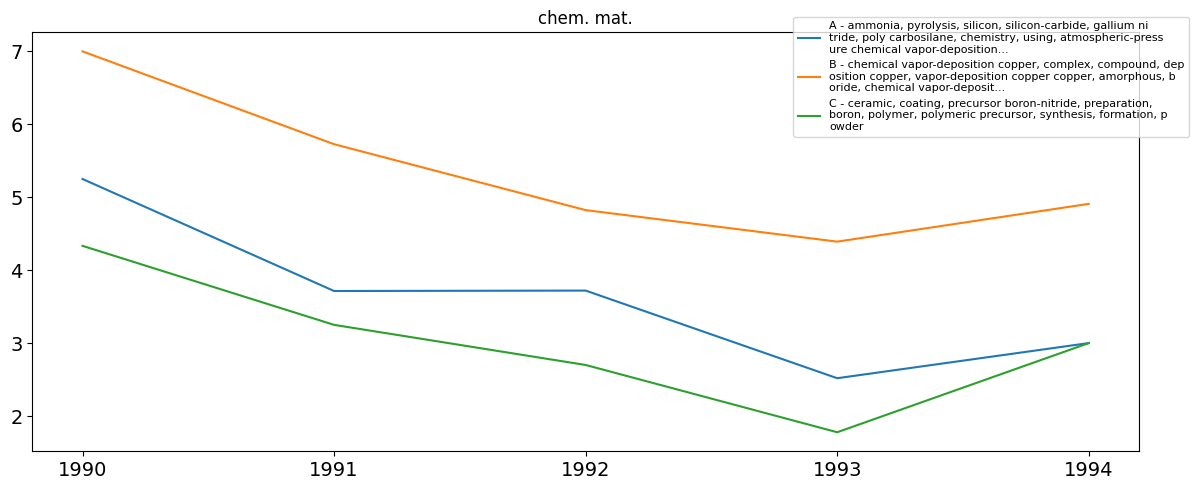

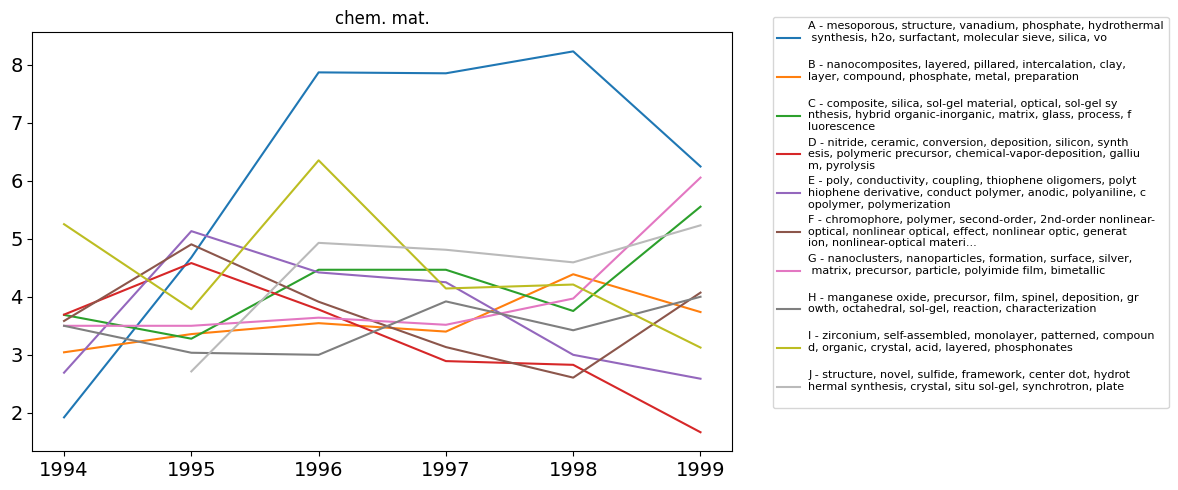

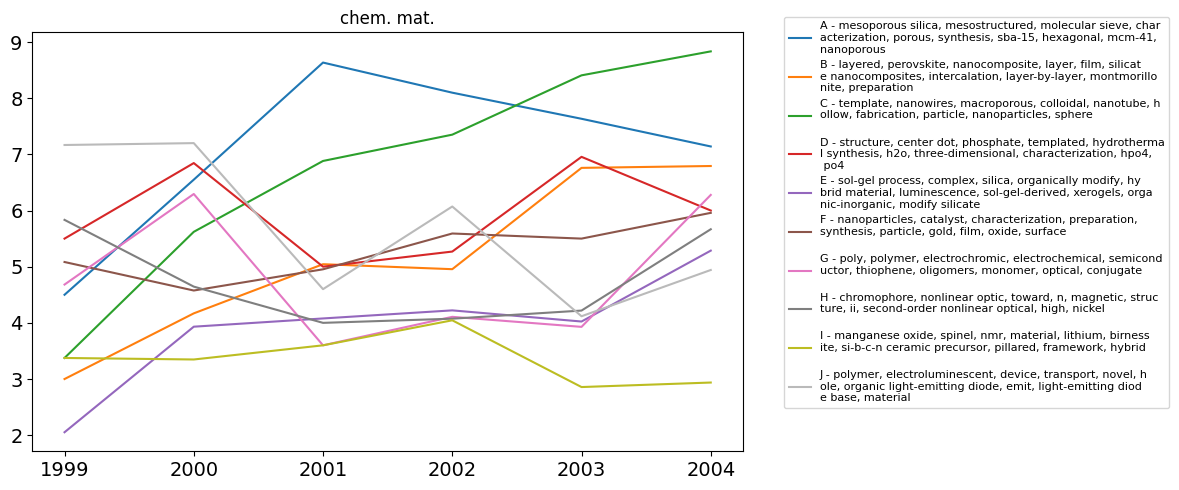

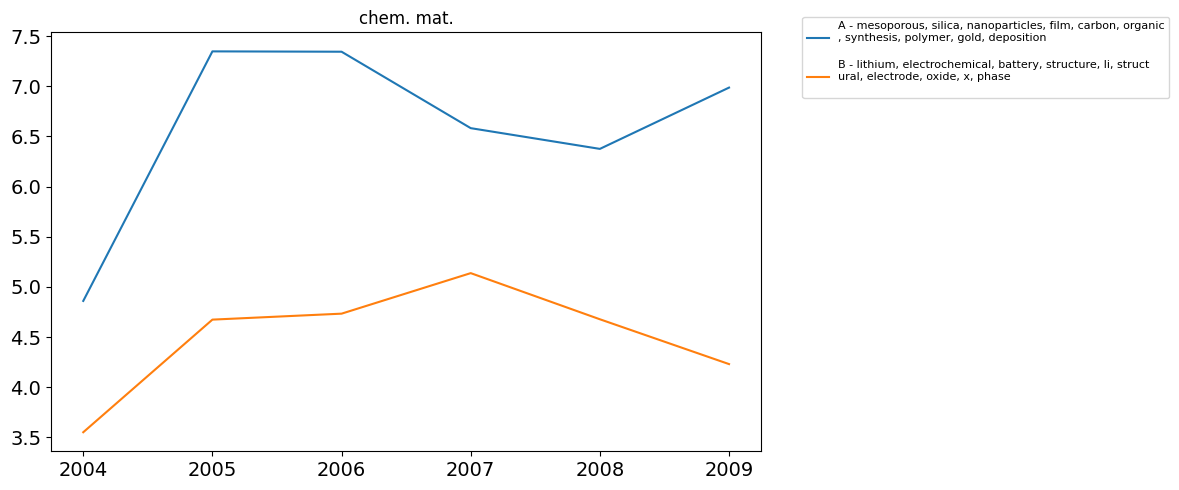

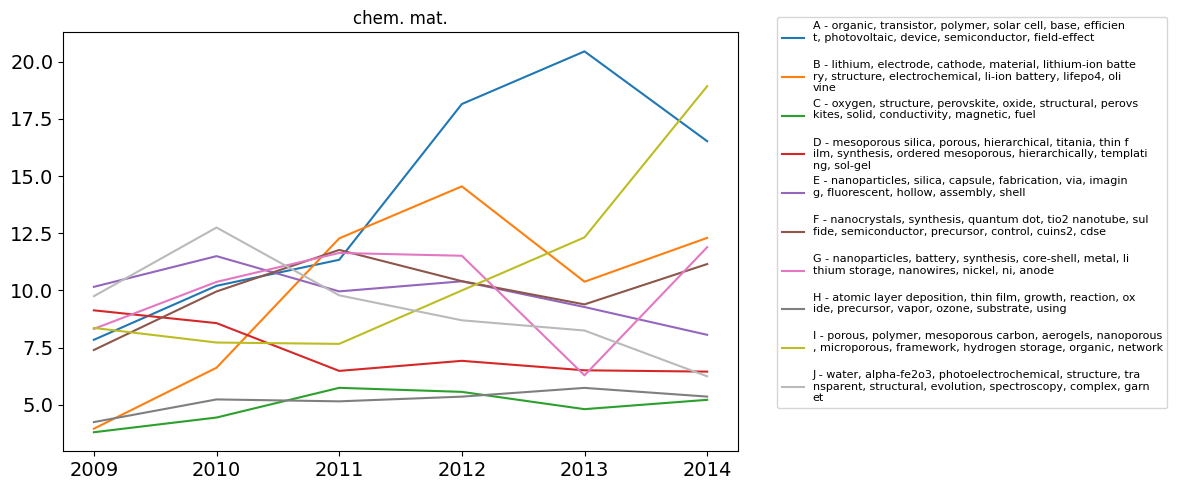

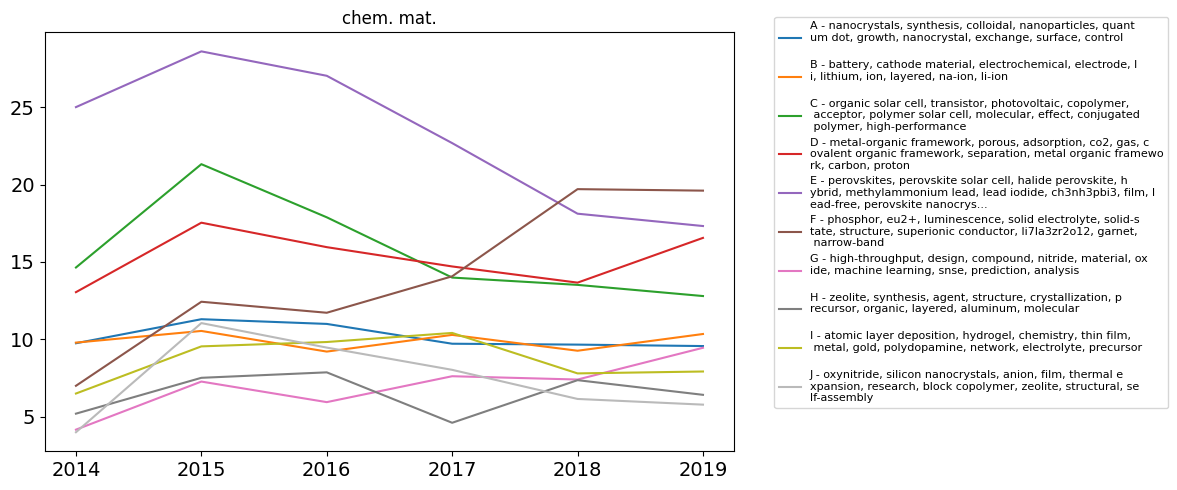

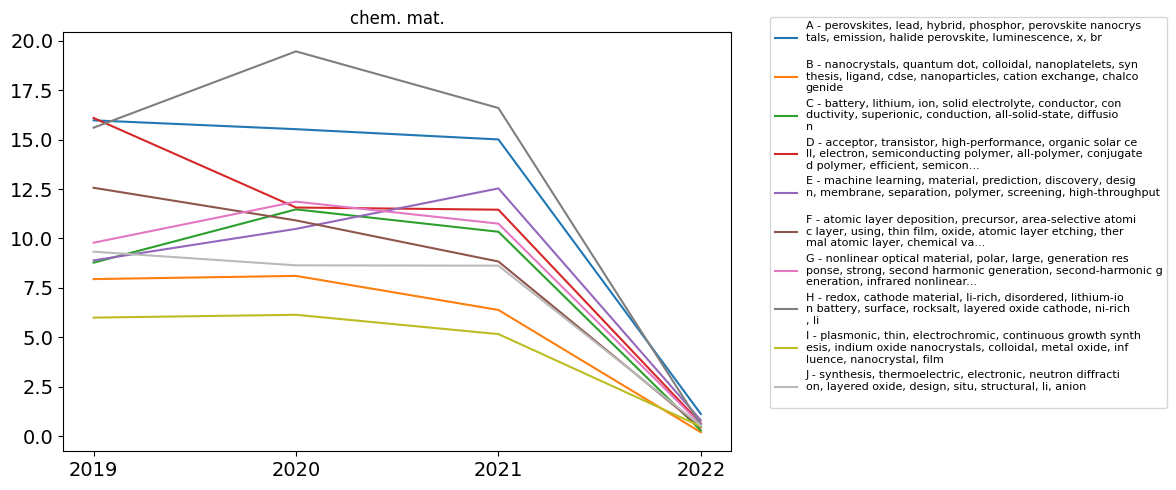

In [107]:
def plot_impact_factor_window(file):
    cmap = plt.get_cmap("tab10")
    outer_colors = cmap(np.arange(10))
    outer_colors[-1][0] = 0.73
    outer_colors[-1][1] = 0.73
    outer_colors[-1][2] = 0.73
    outer_colors[-1][3] = 1.0
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14) 
    
    fg = plt.figure(figsize=(12, 5))
    ax = fg.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    data = json.loads(open(file).read())
    for journal, comms_data in data.items():
        i = 0
        for comm, year_data in comms_data.items():
            X = []
            Y = []
            for x,y in year_data:
                X.append(x)
                Y.append(y)
            label = comm[:60] + '\n' + comm[60:120] + '\n' + comm[120:]
            plt.plot(X, Y, label=label, color=outer_colors[i])
            i += 1
            if i > 9:
                break
        plt.title(journal)
        plt.legend(prop={'size': 8}, bbox_to_anchor=(1.05,1.05))
        plt.tight_layout()
        plt.savefig('../results/impact_factor_{}_2020.pdf'.format(file[30:-20]))
        
files = glob.glob('cit_net_windows/impact_factor_*.json')
for file in files:
    plot_impact_factor_window(file)